In [13]:
import findspark
findspark.init()

import pyspark
import random

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt

fileName = "/Users/lingzhuo/Desktop/256/Stock/IBMStockData.csv"

#initial a spark cluster
spark = pyspark.sql.SparkSession.builder.appName("StockPrice").config("spark.some.config.option", "some-value").getOrCreate()
#spark = pyspark.sql.SparkSession.builder.master("local").appName("StockMarket").config("spark.executor.memory", "6gb").getOrCreate()
#Use spark.read() to access this. Loads a CSV file and returns the result as a DataFrame.
df = spark.read.csv(fileName, header=True, inferSchema=True)

In [14]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
data = df.select('Open','High','Low','Volume','Close').toPandas()
print(data)
data['Close'] = data['Close'].shift(-5,fill_value= 0)
data.drop(data.tail(5).index,inplace=True)
print(data)
dataset = data.to_numpy()


          Open    High     Low  Volume   Close
0       112.28  112.28  112.28     120  112.28
1       112.53  112.70  112.28  134096  112.30
2       112.28  112.36  112.15   20521  112.17
3       112.17  112.36  112.17   20044  112.33
4       112.32  112.36  112.12   21591  112.25
...        ...     ...     ...     ...     ...
427619  125.92  126.26  125.91   48228  126.22
427620  126.22  126.41  126.22   44881  126.41
427621  126.42  126.50  126.35   44224  126.48
427622  126.49  126.60  126.44   59030  126.59
427623  126.59  126.59  126.25  148971  126.25

[427624 rows x 5 columns]
           Open     High     Low  Volume   Close
0       112.280  112.280  112.28     120  112.20
1       112.530  112.700  112.28  134096  112.27
2       112.280  112.360  112.15   20521  112.36
3       112.170  112.360  112.17   20044  112.72
4       112.320  112.360  112.12   21591  112.63
...         ...      ...     ...     ...     ...
427614  126.130  126.270  126.01   24042  126.22
427615  126.200  

In [15]:
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

#Create the scaled training data set and test data set
train_data = dataset[0:training_data_len]
test_data = dataset[training_data_len :]

print(train_data[0], len(train_data))
print('-------------')
print(test_data[0], len(test_data))


#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

print(scaled_train_data[0])
print('-------------')
print(scaled_test_data[0])

[112.28 112.28 112.28 120.   112.2 ] 342096
-------------
[ 131.78  131.83  131.78 2486.    131.93] 85523
[2.29371079e-01 2.28814922e-01 2.30633237e-01 5.44928034e-06
 2.28033473e-01]
-------------
[0.61869414 0.61644667 0.62568306 0.00098574 0.62094877]


In [16]:
xtrain = scaled_train_data[:, 0:-1]
ytrain = scaled_train_data[:, -1:]

xtest = scaled_test_data[:, 0:-1]
ytest = scaled_test_data[:, -1:]

print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (342096, 4)
xtest shape = (85523, 4)
ytrain shape = (342096, 1)
ytest shape = (85523, 1)


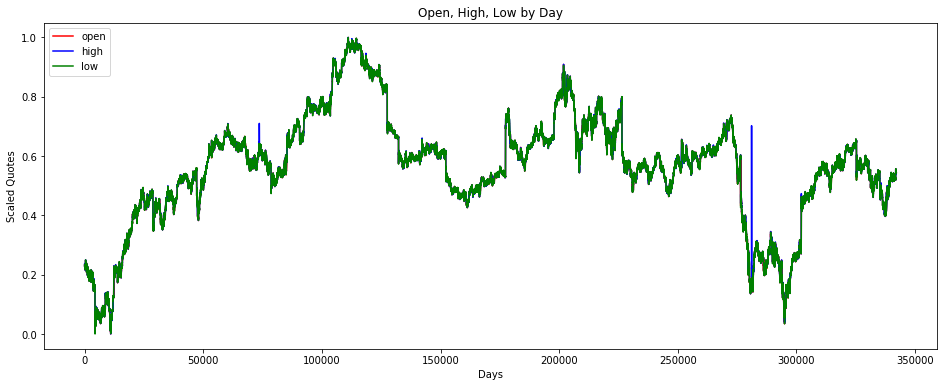

In [17]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

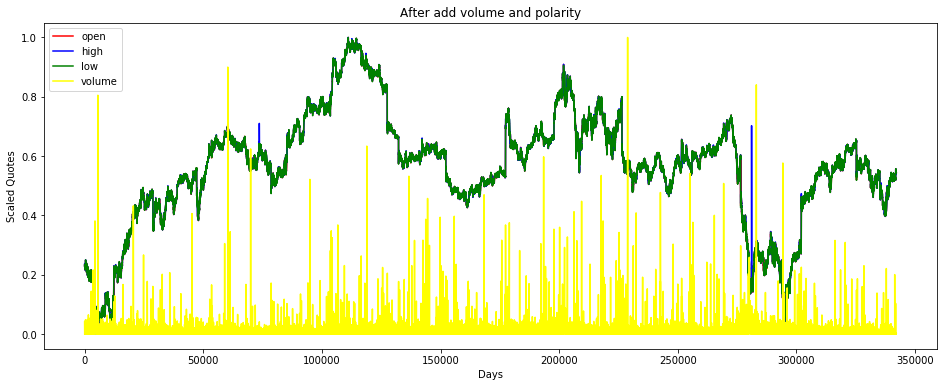

In [18]:
#volume and Polarity are very noisy
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='yellow', label='volume')
#plt.plot(xtrain[:,4],color='purple', label='Polarity')
plt.legend(loc = 'upper left')
plt.title('After add volume and polarity')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [19]:
from keras import models, layers
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,4)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(xtrain.shape)
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
print('The shape of xtrain is {}: '.format(xtrain.shape))
print('The shape of xtest is {}: '.format(xtest.shape))

loss = model.fit(xtrain, ytrain, batch_size=128, epochs=100)

(342096, 4)
The shape of xtrain is (342096, 1, 4): 
The shape of xtest is (85523, 1, 4): 
Epoch 1/100
342096/342096 [==============================] - 8s 23us/step - loss: 0.0124
Epoch 2/100
342096/342096 [==============================] - 6s 18us/step - loss: 1.3666e-04
Epoch 3/100
342096/342096 [==============================] - 5s 15us/step - loss: 9.6702e-05
Epoch 4/100
342096/342096 [==============================] - 5s 16us/step - loss: 6.1608e-05
Epoch 5/100
342096/342096 [==============================] - 8s 25us/step - loss: 3.8995e-05
Epoch 6/100
342096/342096 [==============================] - 17s 50us/step - loss: 2.8448e-05
Epoch 7/100
342096/342096 [==============================] - 16s 47us/step - loss: 2.3286e-05
Epoch 8/100
342096/342096 [==============================] - 10s 30us/step - loss: 2.0390e-05
Epoch 9/100
342096/342096 [==============================] - 5s 14us/step - loss: 1.8529e-05
Epoch 10/100
342096/342096 [==============================] - 5s 15us/step

342096/342096 [==============================] - 14s 42us/step - loss: 1.1511e-05
Epoch 86/100
342096/342096 [==============================] - 12s 34us/step - loss: 1.1569e-05
Epoch 87/100
342096/342096 [==============================] - 15s 44us/step - loss: 1.1509e-05
Epoch 88/100
342096/342096 [==============================] - 13s 38us/step - loss: 1.1482e-05
Epoch 89/100
342096/342096 [==============================] - 12s 36us/step - loss: 1.1480e-05
Epoch 90/100
342096/342096 [==============================] - 13s 38us/step - loss: 1.1503e-05
Epoch 91/100
  6912/342096 [..............................] - ETA: 17s - loss: 1.7240e-05

/anaconda3/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.127716). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


342096/342096 [==============================] - 12s 35us/step - loss: 1.1407e-05
Epoch 92/100
342096/342096 [==============================] - 13s 37us/step - loss: 1.1492e-05
Epoch 93/100
342096/342096 [==============================] - 11s 33us/step - loss: 1.1385e-05
Epoch 94/100
342096/342096 [==============================] - 13s 37us/step - loss: 1.1435e-05
Epoch 95/100
342096/342096 [==============================] - 12s 34us/step - loss: 1.1336e-05
Epoch 96/100
342096/342096 [==============================] - 12s 35us/step - loss: 1.1427e-05
Epoch 97/100
342096/342096 [==============================] - 13s 37us/step - loss: 1.1306e-05
Epoch 98/100
342096/342096 [==============================] - 12s 35us/step - loss: 1.1286e-05
Epoch 99/100
342096/342096 [==============================] - 12s 34us/step - loss: 1.1374e-05
Epoch 100/100
342096/342096 [==============================] - 12s 36us/step - loss: 1.1350e-05


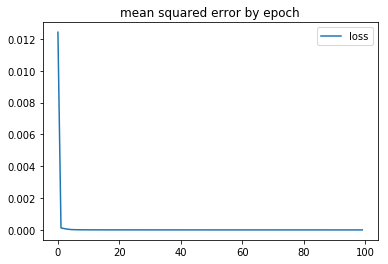

In [20]:
plt.plot(loss.history['loss'], label = 'loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show()

In [21]:
#Getting the models predicted price values
predictions = model.predict(xtest) 
print(predictions)

[[0.61593676]
 [0.61703855]
 [0.61715484]
 ...
 [0.5267644 ]
 [0.5258453 ]
 [0.5256455 ]]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


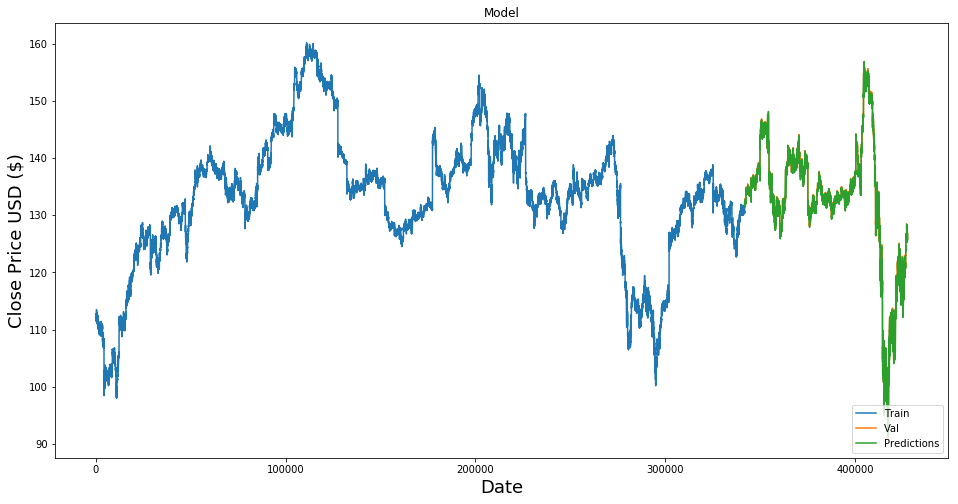

In [22]:
#Undo scaling, show real prediction
# create empty table with 2 fields
trainPredict_dataset_like = np.zeros(shape=(len(predictions), 5) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = predictions[:,0]
# inverse transform and then select the right field
predictions = scaler.inverse_transform(trainPredict_dataset_like)[:,0]


train = data.loc[:training_data_len]
valid = data.loc[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [23]:
#Show the valid and predicted prices
valid

,Open,High,Low,Volume,Close,Predictions
342096,131.780,131.830,131.78,2486,131.93,131.597985
342097,131.860,131.880,131.86,3765,131.94,131.670715
342098,131.870,131.880,131.87,3616,131.96,131.678391
342099,131.870,131.920,131.87,2815,131.98,131.688443
342100,131.940,131.960,131.91,4418,132.02,131.764486
...,...,...,...,...,...,...
427614,126.130,126.270,126.01,24042,126.22,125.973401
427615,126.200,126.200,125.90,12299,126.41,126.097795
427616,125.910,125.990,125.85,19522,126.48,125.711718
427617,125.855,125.910,125.79,24936,126.59,125.651048


In [24]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
from pyspark.ml.evaluation import RegressionEvaluator

df = valid[['Predictions', 'Close']]
print(df)
df_predictions = spark.createDataFrame(df)
rmse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="rmse")
rmse = rmse_evaluator.evaluate(df_predictions)

mse_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mse")
mse = mse_evaluator.evaluate(df_predictions)

mae_evaluator = RegressionEvaluator(labelCol="Close", predictionCol="Predictions", metricName="mae")
mae = mae_evaluator.evaluate(df_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Square Error (MSE) on test data = %g" % mse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

        Predictions   Close
342096   131.597985  131.93
342097   131.670715  131.94
342098   131.678391  131.96
342099   131.688443  131.98
342100   131.764486  132.02
...             ...     ...
427614   125.973401  126.22
427615   126.097795  126.41
427616   125.711718  126.48
427617   125.651048  126.59
427618   125.637859  126.25

[85523 rows x 2 columns]
Root Mean Squared Error (RMSE) on test data = 0.398349
Mean Square Error (MSE) on test data = 0.158682
Mean Absolute Error (MAE) on test data = 0.258491
